# Solution for Homework #1

### TODO
* Write down descriptions of figures on why those results came out
* Apply RNN(LSTM) to address non-markovian behaviors of an agent

### Things to note

* Running a tensorboard alongside this notebook is must. `logdir` should correspond with a `logdir` parameter of an agent instance.
* `Agent.plot_stats()` may fail if buffered events has not been flushed to tensorboard log files. Codes below were written considering this issue. If it fails, just re-run failed cells and they might work.

In [1]:
import os, datetime
from collections import namedtuple
from urllib.parse import urlencode

import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gym

import tf_util, load_policy

//anaconda/envs/rl/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
//anaconda/envs/rl/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Environments

In [2]:
envs = [f.split('.')[0] for f in os.listdir('./experts')]

## Utility Class

In [3]:
class ReplayBuffer:
    def __init__(self):
        self.s = []
        self.a = []
        self.r = []
    
    def add(self, s, a, r):
        self.s.append(s)
        self.a.append(a)
        self.r.append(r)

    def get_batch(self, batch_size):
        for i in range(0, len(self.s), batch_size):
            yield self.s[i:i+batch_size], self.a[i:i+batch_size], self.r[i:i+batch_size]
    
    def concat(self, buf):
        self.s += buf.s
        self.a += buf.a
        self.r += buf.r
        
        return self

## Agents

In [4]:
class ExpertAgent:
    def __init__(self, envname):
        sess = tf.Session()
        with sess.as_default():
            tf_util.initialize()
            self.get_expert_policy = load_policy.load_policy('experts/{}.pkl'.format(envname))

        self.sess = sess
        self.env = gym.make(envname)
    
    def get_action(self, state):
        with self.sess.as_default():
            return self.get_expert_policy(state)
    
    def run_episode(self, max_iter=1):
        maxstep = self.env.spec.max_episode_steps
        
        buf = ReplayBuffer()
        
        for _ in range(max_iter):
            s = self.env.reset()
            
            for _ in range(maxstep):
                a = self.get_action([s])[0]
                s_, r, done, _ = self.env.step(a)
                buf.add(s, a, r)
                s = s_

                if done:
                    break
            
        return buf
    
    def close(self):
        self.sess.close()

In [54]:
class Agent:
    def __init__(self,
                 envname,
                 name=None,
                 learning_rate=0.001,
                 net_size=[200, 100],
                 logdir='tb_log'):
        # Create environments
        env = gym.make(envname)
        s_size = env.observation_space.shape
        a_size = env.action_space.shape
        
        # Create graph
        graph = tf.Graph()

        with graph.as_default():
            s_pl = tf.placeholder(dtype=tf.float32, shape=(None, *s_size), name='state')
            a_pl = tf.placeholder(dtype=tf.float32, shape=(None, *a_size), name='target_action')

            with tf.variable_scope('my_policy'):
                hidden = s_pl
                for i, units in enumerate(net_size):
                    hidden = tf.layers.dense(hidden, units, activation=tf.nn.relu, name='hidden_' + str(i))

                a_logit = tf.layers.dense(hidden, a_size[0], activation=tf.tanh, name='logit')

            with tf.variable_scope('training'):
                loss = tf.losses.mean_squared_error(a_pl, a_logit, reduction=tf.losses.Reduction.MEAN)
                train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
                tf.summary.scalar('loss/MSE', loss)

            summary_merged = tf.summary.merge_all()
        
        # Initialize
        sess = tf.Session(graph=graph)
        
        var_list = graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        sess.run(tf.variables_initializer(var_list))

        agent_name = name if name else 'behavior_clone_' + envname
        ts = datetime.datetime.now()
        logpath = '{}/{}/{}'.format(logdir, agent_name, ts)
        writer = tf.summary.FileWriter(logpath, graph)
        
        # Tensorflow-related
        self.graph = graph
        self.sess = sess
        self.s_pl = s_pl
        self.a_pl = a_pl
        self.a_logit = a_logit
        self.train_op = train_op
        self.writer = writer
        self.summary_merged = summary_merged
        
        self.name = agent_name
        self.ts = ts
        self.logpath = logpath
        
        self.env = env
        self.envname = envname
        
        self.n_iter = 0
        self.n_train = 0
    
    def get_action(self, s):
        return self.sess.run(self.a_logit, feed_dict={self.s_pl: s})
    
    def run_episode(self, max_iter=1):
        maxstep = self.env.spec.max_episode_steps
        buf = ReplayBuffer()
        
        for _ in range(max_iter):
            s = self.env.reset()
            reward = 0
            
            for n_step in range(maxstep):
                a = self.get_action([s])
                s_, r, done, _ = self.env.step(a)
                
                reward += r
                buf.add(s, a, r)

                s = s_

                if done:
                    break

            reward_summary = tf.Summary(value=[tf.Summary.Value(tag='reward', simple_value=reward)])
            self.writer.add_summary(reward_summary, self.n_iter)
            self.n_iter += 1
        
        self.writer.flush()
        
        return buf
    
    def train(self, s_batch, a_target):
        summary, _ = self.sess.run([self.summary_merged, self.train_op],
                                   feed_dict={self.s_pl: s_batch, self.a_pl: a_target})
        self.writer.add_summary(summary, self.n_train)
        self.writer.flush()
        self.n_train += 1
    
    def tensorboard_scalar_url(self, tag):
        tb_url = 'http://localhost:6006/data/plugin/scalars/scalars'
        query = {
            'run': '{}/{}'.format(self.name, self.ts),
            'tag': tag,
            'format': 'csv'
        }
        
        return '{}?{}'.format(tb_url, urlencode(query))
    
    def plot_stats(self, axes=None):
        if not axes:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
            fig.suptitle(self.name, fontsize=16)
        
        reward_df = pd.read_csv(self.tensorboard_scalar_url('reward'))
        loss_df = pd.read_csv(self.tensorboard_scalar_url('training/loss/MSE'))
        
        reward_ax = reward_df.plot(x='Step', y='Value', title='reward', ax=axes[0])
        loss_ax = loss_df.plot(x='Step', y='Value', title='loss/MSE', ax=axes[1])
        
        return reward_ax, loss_ax
    
    def get_rewards(self):
        return pd.read_csv(self.tensorboard_scalar_url('reward'), usecols=['Value']).Value.values
    
    def close(self):
        self.writer.close()
        self.sess.close()

## Hyperparameters

In [66]:
batch_size = 64
maxiter = 50

## Populate Expert Data

In [82]:
experts = {}
target_data = {}
expert_rewards = {}

for envname in envs:
    expert = ExpertAgent(envname)
    buf = ReplayBuffer()
    rewards = []
    
    for _ in range(maxiter):
        iterbuf = expert.run_episode()
        buf.concat(iterbuf)
        rewards.append(sum(iterbuf.r))
    
    experts[envname] = expert
    target_data[envname] = buf
    expert_rewards[envname] = np.array(rewards)

obs (1, 111) (1, 111)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 17) (1, 17)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 17) (1, 17)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
obs (1, 11) (1, 11)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: g

## Behavior Cloning

In [89]:
def fit_behavior_cloning_agent(envname):
    agent = Agent(envname, name='behavior_clone_' + envname)
    
    for s_batch, a_batch, _ in target_data[envname].get_batch(batch_size):
        agent.train(s_batch, a_batch)
    
    # Populate episode data in advanced to plot stats
    agent.run_episode(maxiter)
    agent.close()
    
    return agent

In [90]:
bc_agents = [fit_behavior_cloning_agent(envname) for envname in envs]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

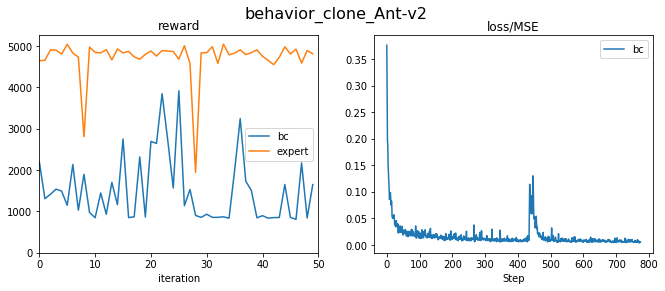

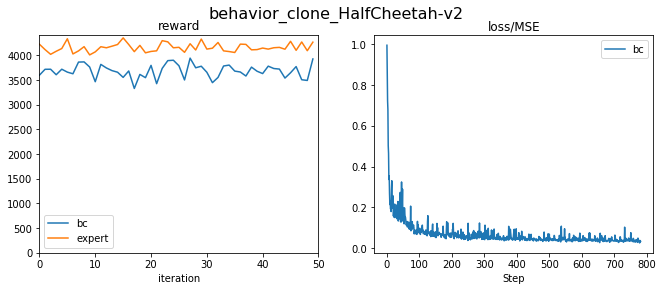

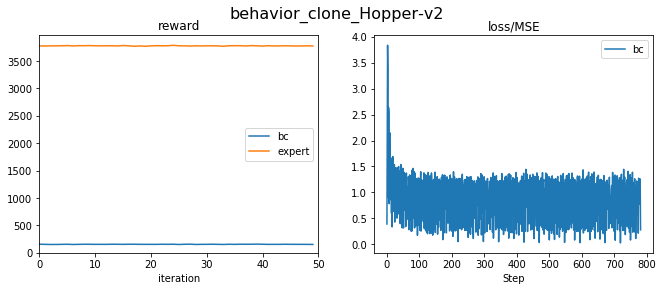

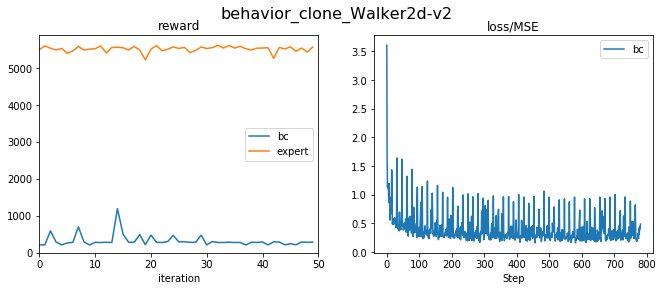

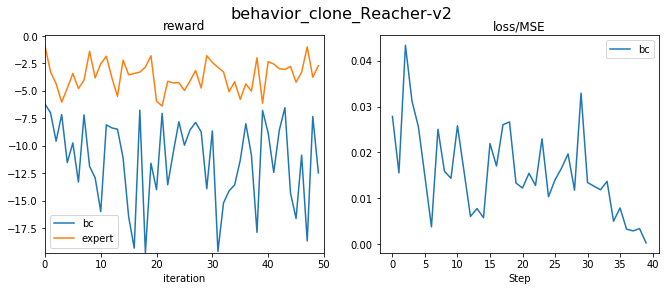

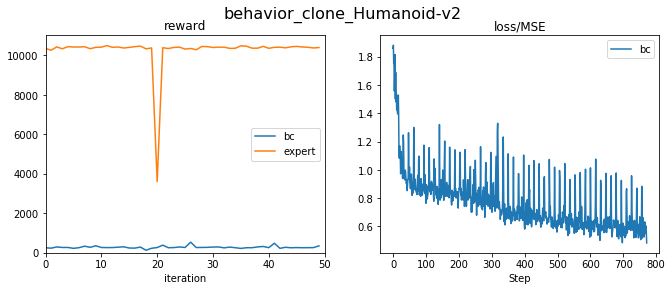

In [91]:
for agent in bc_agents:
    exp_rewards = expert_rewards[agent.envname]
    agent_rewards = agent.get_rewards()
    
    reward_ax, loss_ax = agent.plot_stats()
    reward_ax.plot(np.arange(exp_rewards.size), exp_rewards)
    
    y_min = min(agent_rewards.min(), exp_rewards.min())
    reward_ax.set_xlabel('iteration')
    reward_ax.set_xlim(0, maxiter)
    reward_ax.set_ylim(bottom=min(0, y_min))
    reward_ax.legend(['bc', 'expert'])
    
    loss_ax.legend(['bc'])

In [93]:
data = {
    'bc_mean': [],
    'bc_std': [],
    'expert_mean': [],
    'expert_std': []
}

for agent in bc_agents:
    agent_rewards = agent.get_rewards()
    exp_rewards = expert_rewards[agent.envname]
    
    data['bc_mean'].append(agent_rewards.mean())
    data['bc_std'].append(agent_rewards.std())
    data['expert_mean'].append(exp_rewards.mean())
    data['expert_std'].append(exp_rewards.std())

indices = [agent.envname for agent in bc_agents]

df = pd.DataFrame(data, indices)
df

,bc_mean,bc_std,expert_mean,expert_std
Ant-v2,1516.460469,797.666328,4718.227228,500.191600
HalfCheetah-v2,3680.488384,135.257893,4155.599462,85.718879
Hopper-v2,154.790842,1.456958,3778.147422,3.209244
Walker2d-v2,323.553274,159.821622,5511.404051,75.932384
Reacher-v2,-11.346972,3.812171,-3.623627,1.340968
Humanoid-v2,280.607676,60.919709,10263.724218,952.151562


### Hyperparameter tuning

In [94]:
hyp_agents = {}
net_sizes = [[200, 100, 50], [100, 100], [50]]
for envname in envs:
    for net_size in net_sizes:
        agent = Agent(envname, net_size=net_size)
        
        for s_batch, a_batch, _ in target_data[envname].get_batch(batch_size):
            agent.train(s_batch, a_batch)
        
        agent.run_episode(maxiter)
        
        agents = hyp_agents.get(envname, [])
        agents.append(agent)
        hyp_agents[envname] = agents
        
        agent.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

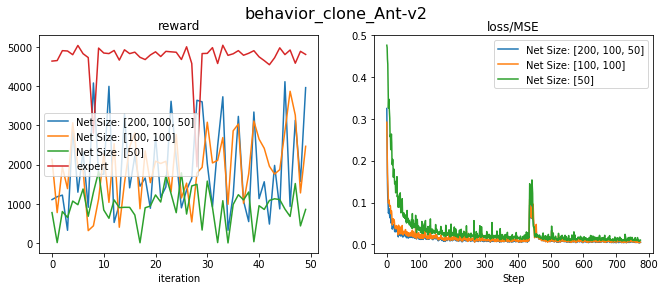

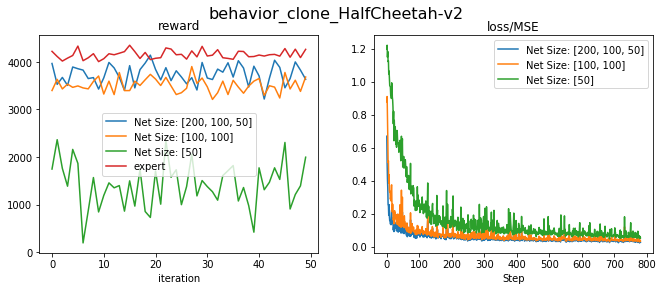

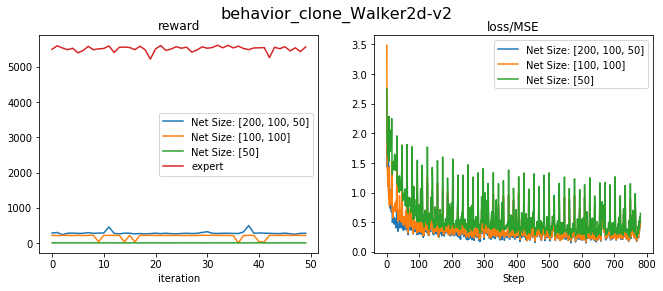

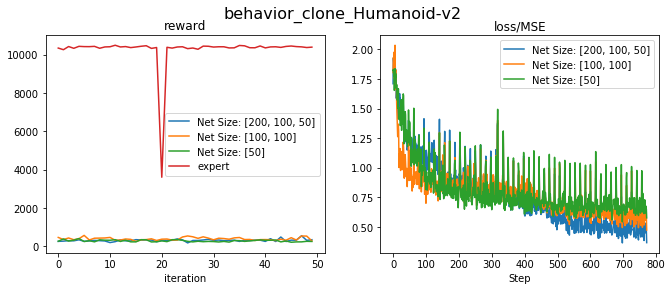

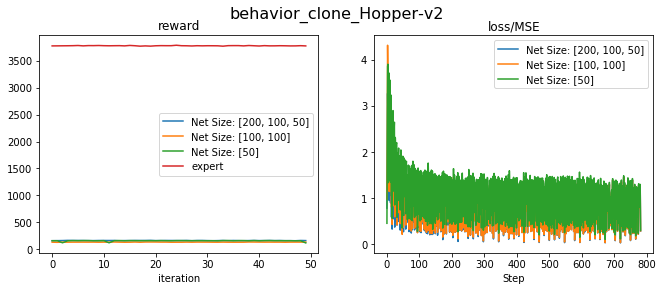

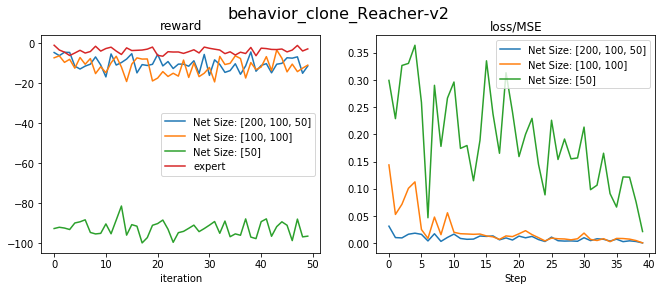

In [97]:
legends = ['Net Size: {}'.format(net_size) for net_size in net_sizes]
for envname, agents in hyp_agents.items():
    exp_rewards = expert_rewards[envname]
    
    axes = None
    for agent in agents:
        axes = agent.plot_stats(axes)
        
    reward_ax, loss_ax = axes
    reward_ax.plot(np.arange(exp_rewards.size), exp_rewards)

    reward_ax.set_xlabel('iteration')
    reward_ax.legend(legends + ['expert'])
    loss_ax.legend(legends)

## DAgger

In [98]:
def fit_dagger_agent(envname):
    agent = Agent(envname, name='dagger_' + envname)
    expert = experts[envname]
    
    buf = ReplayBuffer()
    
    for _ in range(maxiter):
        episode_buf = agent.run_episode()
        buf.concat(episode_buf)

        for s_batch, _, _ in buf.get_batch(batch_size):
            expert_action = expert.get_action(s_batch)
            agent.train(s_batch, expert_action)
    
    agent.close()
    
    return agent

In [99]:
dagger_agents = [fit_dagger_agent(envname) for envname in envs]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

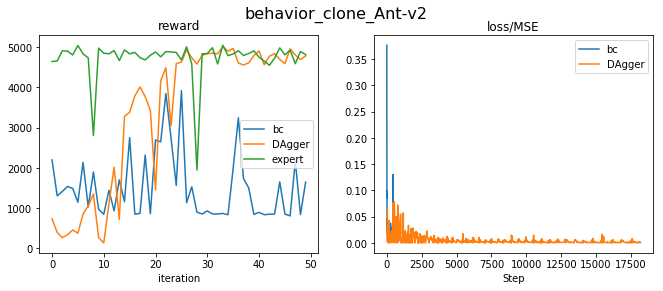

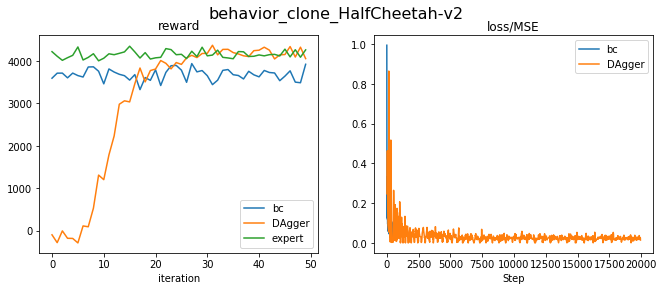

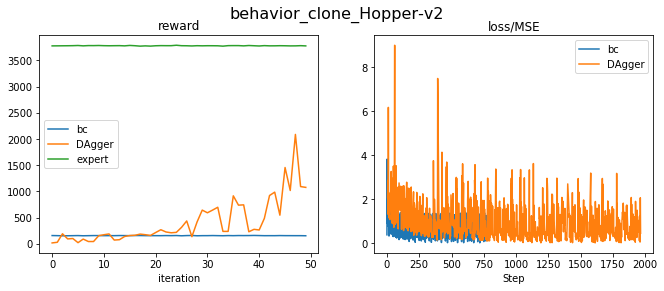

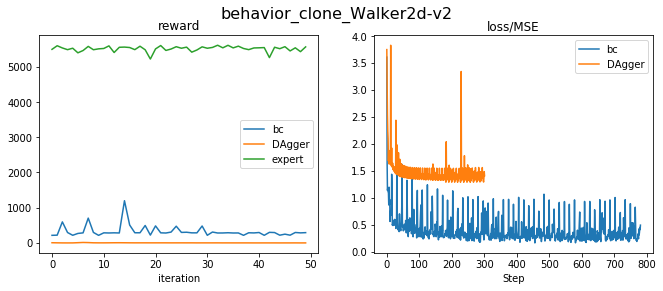

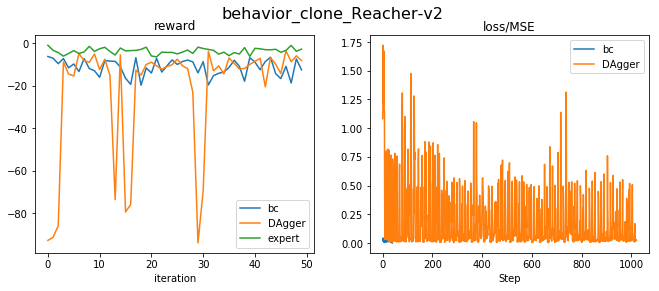

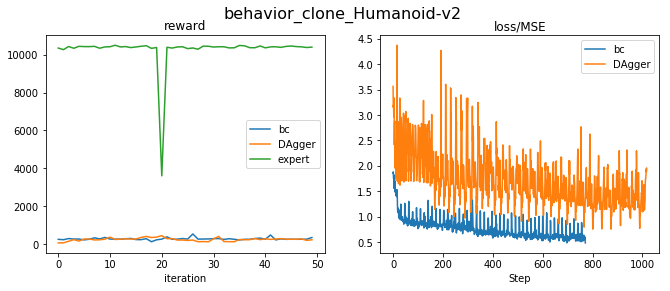

In [100]:
for bca, da in zip(bc_agents, dagger_agents):
    exp_rewards = expert_rewards[bca.envname]
    
    axes = bca.plot_stats()
    reward_ax, loss_ax = da.plot_stats(axes)
    
    reward_ax.plot(np.arange(exp_rewards.size), exp_rewards)
    reward_ax.set_xlabel('iteration')
    reward_ax.legend(['bc', 'DAgger', 'expert'])
    
    loss_ax.legend(['bc', 'DAgger'])